In [5]:
from visual_genome.local import VisualGenome
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
import pandas as pd
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer
from nltk.cluster import KMeansClusterer
from scipy.spatial import distance_matrix, distance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

c:\Users\karab\Desktop\Visual Genome\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Sample images from the dataset, save them to a txt file called `ids.txt` line by line. Then read the file and create the corresponding csv file below.


In [2]:
# read ids.txt
ids = []
with open('ids.txt', 'r') as f:
    for line in f:
        ids.append(int(line.strip()))
ids[:5]

[2392778, 2350124, 2331619, 1568, 2351423]

In [3]:
vg = VisualGenome()

Loading data...
Data loaded.


In [4]:
regions = []
images = vg.get_images()
for id in ids:
    image_regions = images[id]["regions"]
    region_sentences = []

    for region in image_regions:
        region_sentences.append(region.phrase.lower())
    regions.append(region_sentences)

images_regions = pd.DataFrame(list(zip(ids, regions)), columns =['Image_id', 'region_sentences'])
images_regions.to_csv('image_regions.csv', index=False)

### Sentence Transformer

For now, I'll use `all-mpnet-base-v2`. This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search. 

Source: https://sbert.net/docs/sentence_transformer/pretrained_models.html

TODO: Check other models in the leaderboard: https://huggingface.co/spaces/mteb/leaderboard  (Look for clustering) \
Maybe we can go for bigger models to get better clusters?

`all-mpnet-base-v2`: Rank 80 for clustering (17/09/24). Average score: 43.69 (109M params) \
`Alibaba-NLP/gte-large-en-v1.5`: Rank 20 for clustering (17/09/24). Average score: 47.96 - (434M params)



In [5]:
models = [
    'all-mpnet-base-v2',  # approx 8 min to load the model
    'gte-large-en-v1.5',  # approx 17 min to load the model
]
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # takes approx 5 min to load

# model = SentenceTransformer("all-mpnet-base-v2", trust_remote_code=True).cuda()
model_name = 'all-mpnet-base-v2'

c:\Users\karab\Desktop\Visual Genome\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
def get_embeddings(model, region_sentences):
    sentence_embeddings = model.encode(region_sentences)
    return sentence_embeddings

image_regions_csv = pd.read_csv("image_regions.csv")
image_regions_csv.head()

,Image_id,region_sentences
0,2392778,"['this is a tennis ball', 'the ball is green i..."
1,2350124,"['this is the sky', 'the sky is blue in color'..."
2,2331619,"['the sky is blue in color', 'this is the gras..."
3,1568,"['man walking on sidewalk', 'parking meter nex..."
4,2351423,"['a banana on a table', 'a banana laying flat'..."


In [8]:
image_regions_csv["region_sentences"] = image_regions_csv["region_sentences"].apply(eval)
regions = image_regions_csv["region_sentences"].tolist()

In [9]:
len(regions) # 10k images

10000

### Get Embeddings

In [10]:
embeddings = []
for image_regions in regions:
    # returns a list of lists, one 768-length embedding per region sentence. 
    # Number of rows corresponds to number of sentences

    # image_regions: list of regions for the same image
    if image_regions:
        emb = get_embeddings(model, image_regions)
        # get mean value columnwise, so that sentence embeddings are averaged per region for each image
        emb = np.mean(np.array(emb), axis=0) 
        # for each model, a 768-length embedding is stored
        embeddings.append(emb)
    else:
        embeddings.append(0)
len(embeddings)  # takes approx 8 min to run

10000

In [11]:
image_regions_csv["embeddings"] = pd.Series(embeddings, index=image_regions_csv.index)  # add embeddings to the csv

In [12]:
image_regions_csv.head()

,Image_id,region_sentences,embeddings
0,2392778,"[this is a tennis ball, the ball is green in c...","[-0.006789765, -0.019286059, -0.009381593, 0.0..."
1,2350124,"[this is the sky, the sky is blue in color, th...","[-0.0045183613, -0.021082494, 0.0032845489, 0...."
2,2331619,"[the sky is blue in color, this is the grass, ...","[0.013235334, -0.025800465, 0.00024033694, 0.0..."
3,1568,"[man walking on sidewalk, parking meter next t...","[-0.0131078735, -0.009918882, 0.017939541, 0.0..."
4,2351423,"[a banana on a table, a banana laying flat, a ...","[0.059326038, -0.051246375, -0.024051206, -0.0..."


In [13]:
def cluster(images_regions_csv, num_clusters):
    sentences = images_regions_csv['region_sentences']
    X = np.array(images_regions_csv["embeddings"].tolist())

    data = images_regions_csv[['Image_id', 'region_sentences', "embeddings"]].copy()
    kclusterer = KMeansClusterer(
        num_clusters, distance=nltk.cluster.util.cosine_distance,
        avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(data["embeddings"], assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row["embeddings"]], [row['centroid'].tolist()])[0][0]

In [14]:
def nltk_inertia(feature_matrix, centroid):
    sum_ = []
    for i in range(feature_matrix.shape[0]):
        sum_.append(np.sum((feature_matrix[i] - centroid[i])**2))  
    return sum(sum_) 

def number_of_clusters(image_regions_csv, model_name):
    sse = [] # sum of squared distance
    list_k = list(range(10, 300, 10))

    for k in list_k:
        data, assigned_clusters = cluster(image_regions_csv, k)
        sse.append(nltk_inertia(data["embeddings"].to_numpy(), data.centroid.to_numpy()))

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.title('Elbow method for '+ model_name)
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters k')
    plt.ylabel('Sum of squared distance')
    plt.show()

In [15]:
# Elbow method does not seem to be a good metric to measure cluster quality due to "curse of dimensionality" - prone to overfitting
# number_of_clusters(image_regions_csv, model_name) # it takes 80 mins for range(10, 300)

In [16]:
n_clusters = 30

def make_clusters(images_regions, n_clusters):
    data, assigned_clusters = cluster(images_regions, n_clusters)
    # Compute centroid distance to the data
    data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)
    return data

In [17]:
def tsne_visual(embedding_clusters, model_name):
    mat = np.asarray([x for x in embedding_clusters["embeddings"]])
    t_sne = TSNE(n_components=2)
    low_dim_data = t_sne.fit_transform(mat)
    print('Lower dim data has shape',low_dim_data.shape)
    tsne_df =  pd.DataFrame(low_dim_data, embedding_clusters['cluster'])
    plt.figure(figsize=(20,12))
    
    # tsne_df - 10000 x 2
    sns.set(rc={"figure.figsize":(12, 16)})
    ax = sns.scatterplot( x=tsne_df[0], y=tsne_df[1], hue=tsne_df.index, palette = "viridis", s=80)
    ax.set_title('T-SNE BERT Embeddings for '+ model_name)
    plt.show()
    return low_dim_data


In [18]:
embedding_clusters=make_clusters(image_regions_csv, n_clusters) # takes approx 12 seconds
embedding_clusters.head(5)

,Image_id,region_sentences,embeddings,cluster,centroid,distance_from_centroid
0,2392778,"[this is a tennis ball, the ball is green in c...","[-0.006789765, -0.019286059, -0.009381593, 0.0...",20,"[-0.008477622, -0.04510827, 3.606822e-05, 0.02...",0.362256
1,2350124,"[this is the sky, the sky is blue in color, th...","[-0.0045183613, -0.021082494, 0.0032845489, 0....",16,"[-0.0072877686, -0.013672549, 0.0023681005, 0....",0.190628
2,2331619,"[the sky is blue in color, this is the grass, ...","[0.013235334, -0.025800465, 0.00024033694, 0.0...",1,"[0.005621894, -0.027506066, 0.00026491913, 0.0...",0.227243
3,1568,"[man walking on sidewalk, parking meter next t...","[-0.0131078735, -0.009918882, 0.017939541, 0.0...",0,"[-0.0057896734, -0.020595286, 0.0048444993, 0....",0.285439
4,2351423,"[a banana on a table, a banana laying flat, a ...","[0.059326038, -0.051246375, -0.024051206, -0.0...",19,"[0.024108486, -0.032631062, -0.009237658, 0.00...",0.481262


In [19]:
# save embedding_clusters
csv_name = "categories_{}_{}clusters.csv".format(model_name, n_clusters)
embedding_clusters.to_csv(csv_name, index=False)

# save only image ids and clusters
image_clusters = embedding_clusters[['Image_id', 'cluster']]
image_clusters.to_csv("categories_{}_{}clusters_simple.csv".format(model_name, n_clusters), index=False)

In [20]:
def find_distances(images_regions_csv, input_id, input_embedding = np.zeros(5)):
    distances = []     
    image_ids = images_regions_csv.Image_id
    if input_id > 0:
        reference_embedding = images_regions_csv.loc[images_regions_csv.Image_id == input_id]["embeddings"]
        reference_embedding = reference_embedding.values[0].reshape(-1,1)
        corpus_embeddings = images_regions_csv.loc[images_regions_csv.Image_id != input_id]["embeddings"]
    else:
        reference_embedding = input_embedding
        corpus_embeddings = images_regions_csv["embeddings"]
        
    for j in range(len(corpus_embeddings)):  # rows of def_embeddings matrix
        defin = j
        if image_ids[j]!=input_id:      # avoid calculating distance with itself
            corpus = corpus_embeddings[j].reshape(-1,1)
            # euclidean distance between multidimensional vectors
            dist = distance.euclidean(reference_embedding, corpus)
            distances.append([image_ids[j], dist]) 
        
    # store in df
    col_names = ['image_id', 'distances']
    distances_df = pd.DataFrame(distances, columns=col_names)
    distances_df = distances_df.sort_values(by='distances', ascending=True)
    distances_df.to_csv('distances.csv', index=False)
    return distances_df

# given image id to retrieve its k most similar images
def retrieve_images(model_name, image_regions_csv, input_id = -1, input_embedding = np.zeros(5)):
    print('Images retrieved using method:', model_name)
    top_k = 10
    
    if input_id > 0:
    # top_k results to return
        print('Reference image:', input_id)
        vg.visualize_regions(input_id, 0)
        distances_df = find_distances(image_regions_csv, input_id)
    else:
        distances_df = find_distances(image_regions_csv, input_id, input_embedding)
    top_images=distances_df.head(top_k)

    print("Top", top_k, "most similar images to image", input_id, "in Visual Genome:")
    for _, row in top_images.iterrows():   
        im_id = int(row.image_id)
        print("Image id:", im_id, "Euclidean distance: %.4f" % (row.distances))

        # find similar images from api and show
        vg.visualize_regions(input_id, 0)

    return top_images

Lower dim data has shape (10000, 2)


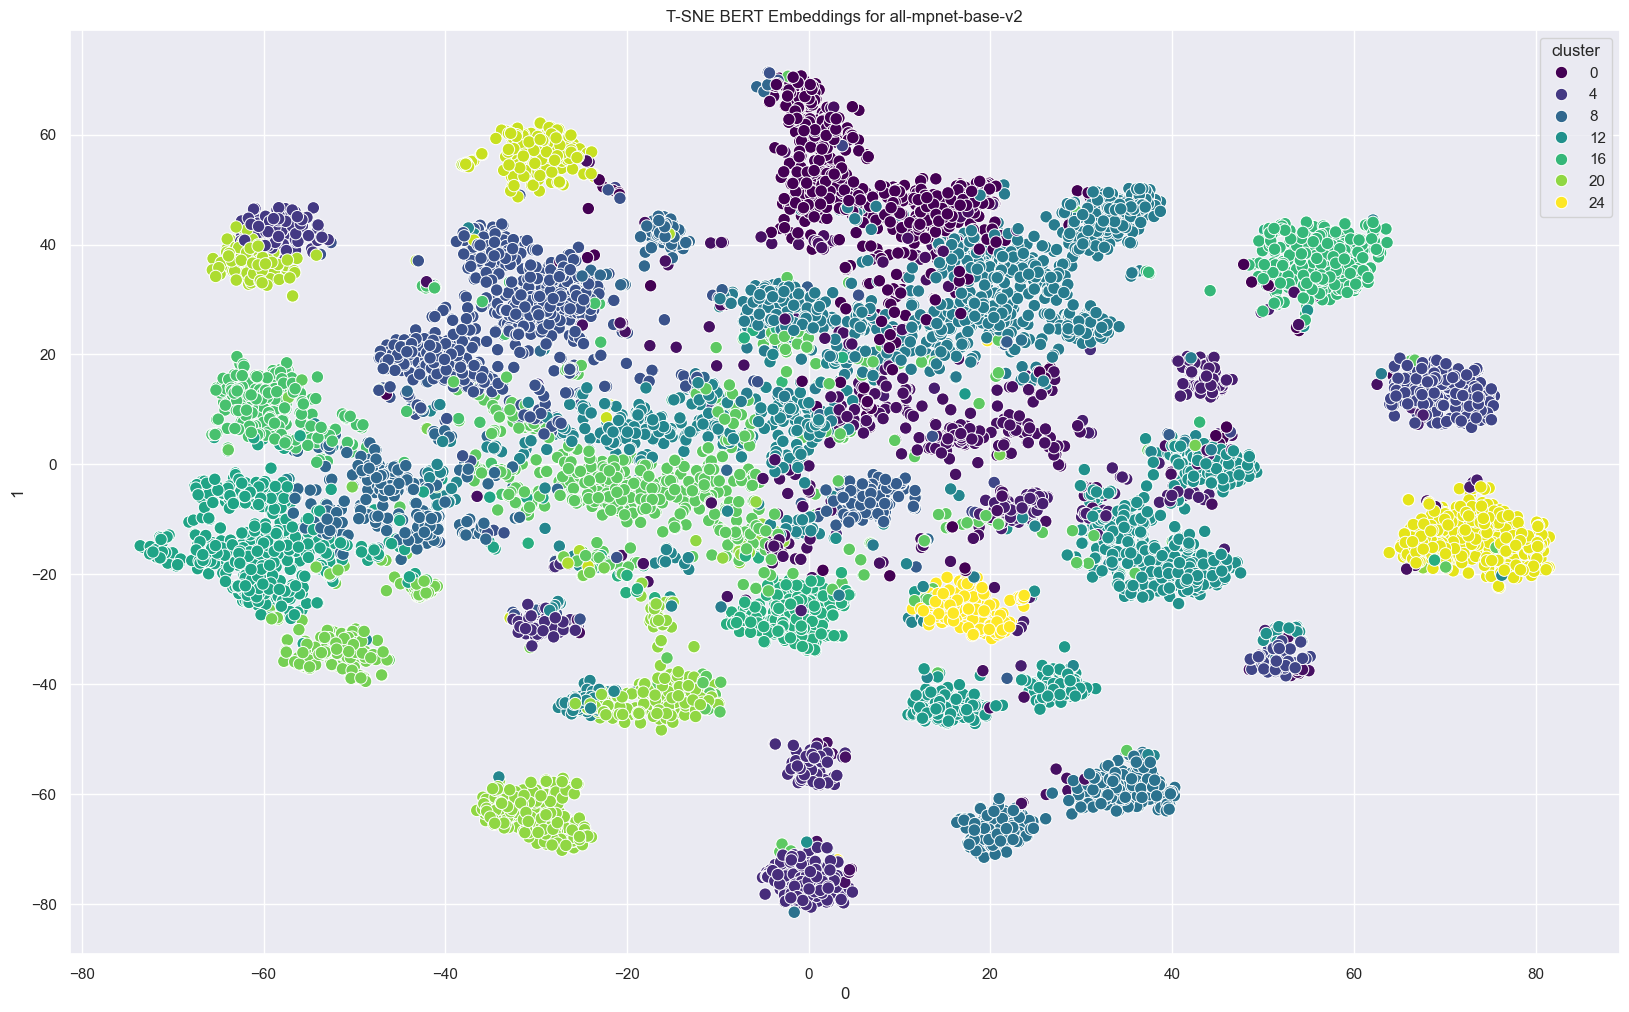

In [21]:
low_embedding_clusters =  tsne_visual(embedding_clusters, model_name)  # takes approx. 

0.21885478


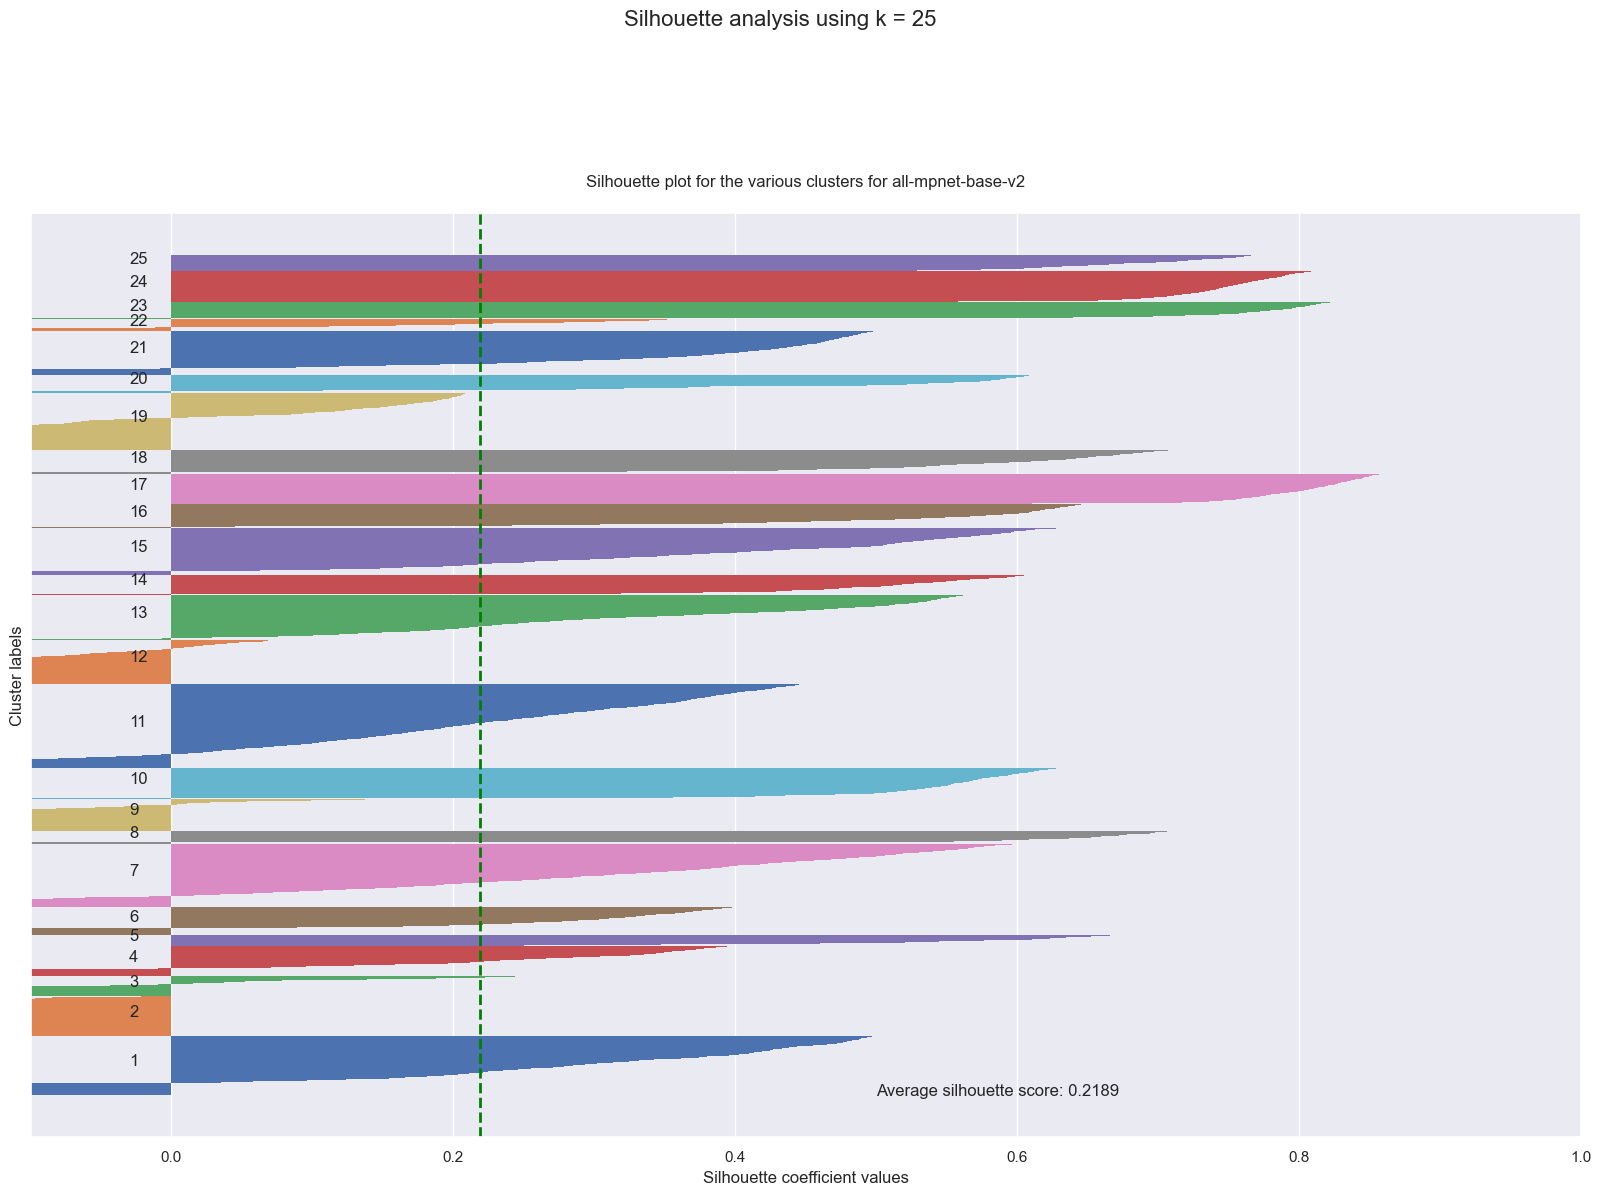

In [22]:
from sklearn.metrics import silhouette_samples

# Get silhouette samples
low_embedding_clusters = low_embedding_clusters
embedding_clusters=embedding_clusters

plt.figure(figsize=(20,12))

embedding_samples = low_embedding_clusters
labels = embedding_clusters['cluster'].to_numpy()
silhouette_vals = silhouette_samples(embedding_samples, labels)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)


avg_score = np.mean(silhouette_vals)
print(avg_score)
plt.axvline(avg_score, linestyle='--', linewidth=2, color='green')
plt.yticks([])
plt.xlim([-0.1, 1])
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster labels')
plt.title(f'Silhouette plot for the various clusters for {model_name}', y=1.02);
plt.text(0.5, 0.5, 'Average silhouette score: %.4f' % avg_score, fontsize=12)


plt.suptitle(f'Silhouette analysis using k = {n_clusters}',
             fontsize=16, y=1.05)
# save silhouette plot
plt.savefig(f'silhouette_plot_{model_name}_{n_clusters}clusters.png')
plt.show()



In [23]:
# read cluster csv
embedding_clusters = pd.read_csv(csv_name)
embedding_clusters.head()

,Image_id,region_sentences,embeddings,cluster,centroid,distance_from_centroid
0,2392778,"['this is a tennis ball', 'the ball is green i...",[-6.78976486e-03 -1.92860588e-02 -9.38159321e-...,20,[-8.47762171e-03 -4.51082699e-02 3.60682207e-...,0.362256
1,2350124,"['this is the sky', 'the sky is blue in color'...",[-4.51836130e-03 -2.10824944e-02 3.28454887e-...,16,[-7.28776865e-03 -1.36725493e-02 2.36810045e-...,0.190628
2,2331619,"['the sky is blue in color', 'this is the gras...",[ 1.32353343e-02 -2.58004647e-02 2.40336944e-...,1,[ 5.62189380e-03 -2.75060665e-02 2.64919130e-...,0.227243
3,1568,"['man walking on sidewalk', 'parking meter nex...",[-1.31078735e-02 -9.91888158e-03 1.79395415e-...,0,[-5.78967342e-03 -2.05952860e-02 4.84449929e-...,0.285439
4,2351423,"['a banana on a table', 'a banana laying flat'...",[ 5.93260378e-02 -5.12463748e-02 -2.40512062e-...,19,[ 2.41084863e-02 -3.26310620e-02 -9.23765823e-...,0.481262


In [34]:
vg.visualize_cluster(embedding_clusters, cluster = 8, n = 3)  